# Introduction

Caravan-MultiMet is an extension to the Caravan dataset presented by [Kratzert et al in 2022](https://www.nature.com/articles/s41597-023-01975-w).

It enriches the meteorological forcing data of Caravan, adding three precipitation nowcast products (CPC, IMERG v07 Early, CHIRPS) and three weather forecast products (ECMWF IFS HRES, GraphCast, CHIRPS-GEFS) to the existing ERA5-Land reanalysis data. The data is publicly available at Zenodo, and on Google Cloud Platform (GCP) under a CC-BY-4.0 license.

**Note** All meteorological data for all basins is in UTC+0 time zone, which is the native temporal resolution of all meteorological products. This is different to the original Caravan dataset, where the daily aggregates of ERA5-Land where computed in local time of each gauge.

## Purpose of this notebook

This notebook exemplifies how to read the Caravan-MultiMet data from the GCP bucket. This allows immediate access to any subset of the data without downloading the entire dataset, thanks to the zarr format in which the data is stored.

## Related resources
The data is also available for download in Zenodo:
*   Nowcasts: https://zenodo.org/records/14161235 (10.5281/zenodo.14161235)
*   Forecasts: https://zenodo.org/records/14161281 (10.5281/zenodo.14161281)

And is accompanied by the paper [Caravan MultiMet: Extending Caravan with Multiple Weather Nowcasts and Forecasts](https://arxiv.org/abs/2411.09459) by Shalev and Kratzert, 2024.

# Run on Colab

This notebook can be executed on Colab by clicking on the button below. This is our recommended way to dive into the MultiMet extension so that you don't need to worry about setting up a local environment for first data inspections.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kratzert/Caravan/blob/main/examples/Caravan_MultiMet_Extending_Caravan_with_Multiple_Weather_Nowcasts_and_Forecasts.ipynb)



# Setup

In [ ]:
# Execute this block when running on Colab to install the missing xarray package.
!pip install zarr xarray

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 17.0 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=c95b69262855c1927c8be75eff75cae6089976354c10af49702ef764fa268621
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.metrics import r2_score

In [ ]:
def open_zarr(path):
  return xr.open_zarr(
      store=path, chunks=None, storage_options=dict(token='anon')
  )

In [ ]:
products = [
    'CPC',
    'IMERG',
    'CHIRPS',
    'ERA5_LAND',
    'CHIRPS_GEFS',
    'HRES',
    'GRAPHCAST',
]
zarr_path_template = 'gs://caravan-multimet/v1.1/{}/timeseries.zarr/'

product_to_dataset = {
    product: open_zarr(zarr_path_template.format(product))
    for product in products
}

At this point, no meteorological data is loaded into memory, only the structure and the indices of the datasets were loaded.

Since the different products have different temporal availability, the time index differs. The same for the available number of basins, which differs due to differences in the spatial coverage of the data products. Most noteably CHIRPS/CHIRPS-GEFS, which is only available between [-50, 50] latitude.

In [ ]:
# Print summary of the different data products.
for product_name, ds in product_to_dataset.items():
  print(f'{product_name}:\n - Number of basins {len(ds["basin"])}')
  print(f' - Start time {ds["date"].values[0]}')
  print(f' - End time {ds["date"].values[-1]}')
  if "lead_time" in ds.coords:
    print(f' - Number of forecast time steps {len(ds["lead_time"])}')
  bands = "".join([f"   - {str(x)}\n" for x in ds.data_vars])
  print(f" - Bands: \n{bands}")

CPC:
 - Number of basins 22492
 - Start time 1979-01-01T00:00:00.000000000
 - End time 2024-07-31T00:00:00.000000000
 - Bands: 
   - cpc_precipitation

IMERG:
 - Number of basins 22492
 - Start time 2000-06-01T00:00:00.000000000
 - End time 2024-10-31T00:00:00.000000000
 - Bands: 
   - imerg_precipitation

CHIRPS:
 - Number of basins 18655
 - Start time 1981-01-01T00:00:00.000000000
 - End time 2024-07-30T00:00:00.000000000
 - Bands: 
   - chirps_precipitation

ERA5_LAND:
 - Number of basins 22485
 - Start time 1950-01-01T00:00:00.000000000
 - End time 2024-10-31T00:00:00.000000000
 - Bands: 
   - era5land_dewpoint_temperature_2m
   - era5land_potential_evaporation_DEPRECATED
   - era5land_potential_evaporation_FAO_PENMAN_MONTEITH
   - era5land_snow_depth_water_equivalent
   - era5land_surface_net_solar_radiation
   - era5land_surface_net_thermal_radiation
   - era5land_surface_pressure
   - era5land_temperature_2m
   - era5land_total_precipitation
   - era5land_u_component_of_wind_10m

## Nowcast products

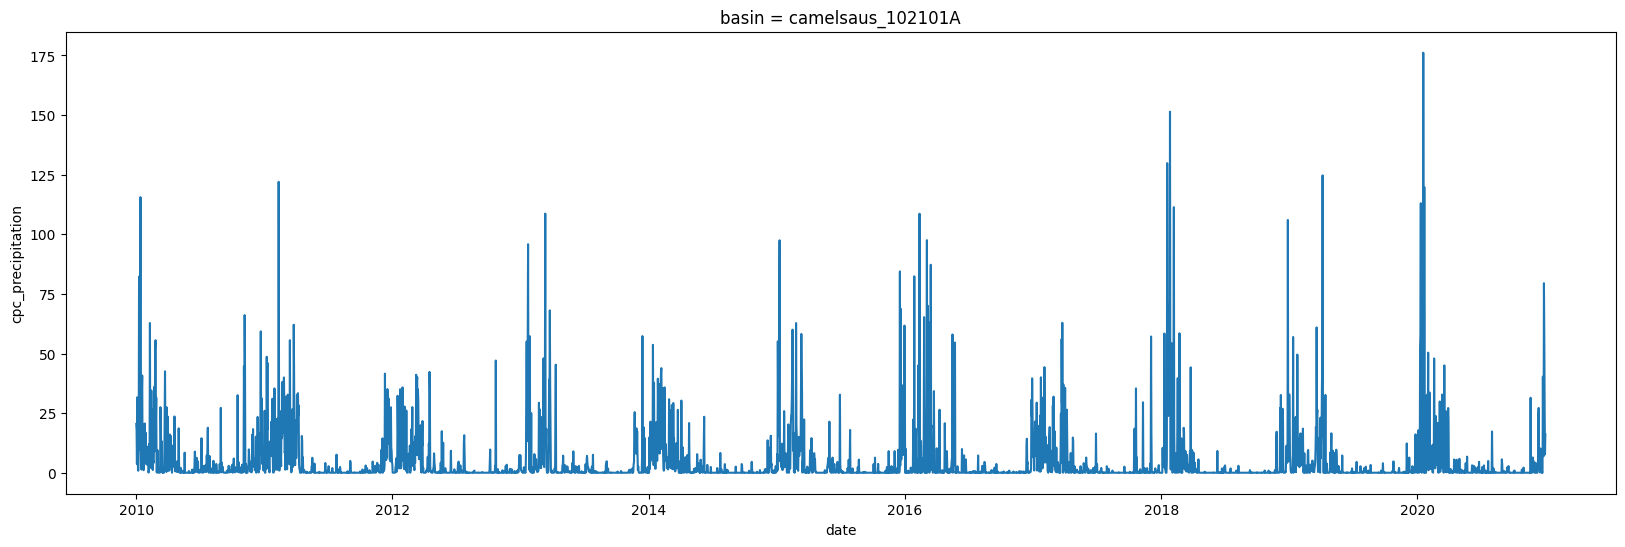

In [ ]:
# Which data?
product = "CPC"
band = "cpc_precipitation"

# Which basin and time period?
basin = "camelsaus_102101A"
time_period = slice("2010", "2020")

ds = product_to_dataset[product]

# Only with the .compute() in this line, data is actually loaded into memory.
ds[band].sel(basin=basin, date=time_period).compute().plot(figsize=(20,6))

## Forecast products

Text(0, 0.5, 'Temperature [°C]')

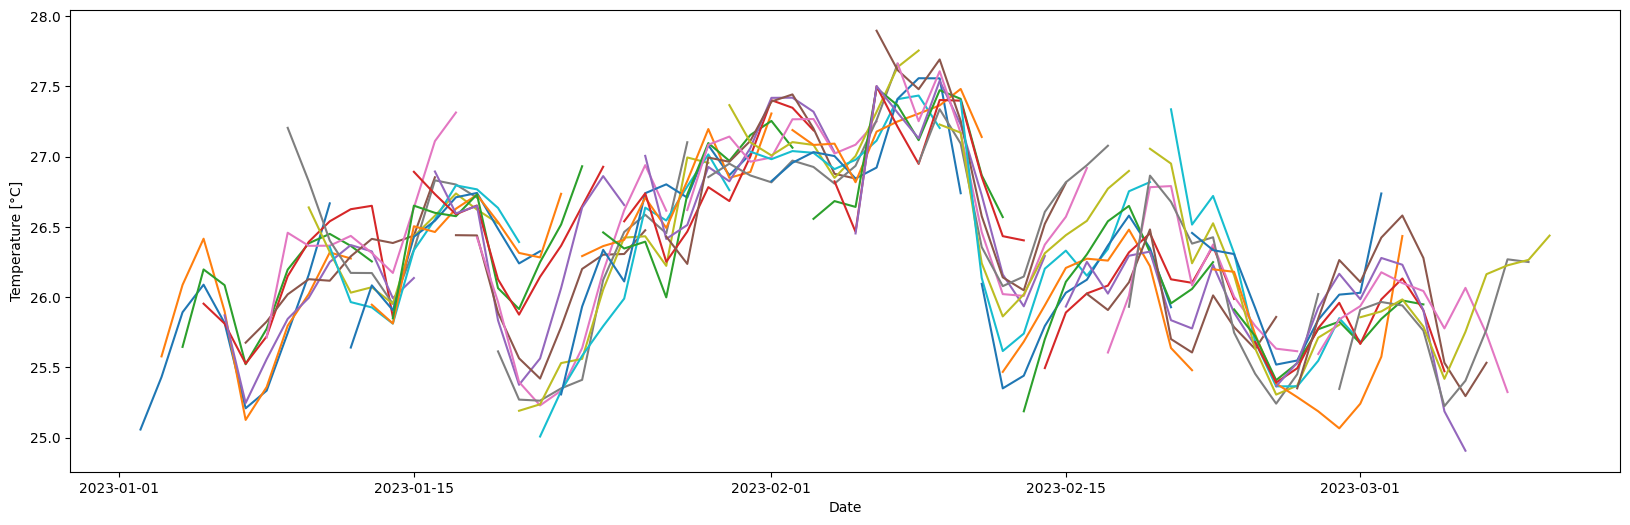

In [ ]:
# Which data?
product = "GRAPHCAST"
band = "graphcast_temperature_2m"

# Which basin and time period?
basin = "camelsaus_102101A"
time_period = slice("2023-01", "2023-02")

ds = product_to_dataset[product]

# Only with the .compute() in this line, data is actually loaded into memory.
da = ds[band].sel(basin=basin, date=time_period).compute()

fig, ax = plt.subplots(figsize=(20, 6))

# Plot each forecast as a forecast hair.
for issue_time in da["date"].values:
  dates = [issue_time + time_delta for time_delta in da["lead_time"].values]
  ax.plot(dates, da.sel(date=issue_time).values)

ax.set_xlabel("Date")
ax.set_ylabel("Temperature [°C]")

## Example: Code for data verification (section 5.2 in the Caravan MultiMet paper)

In [ ]:
basin = 'GRDC_6217400'
product_to_gauge_ds = {
    product: ds.sel(basin=basin) for product, ds in product_to_dataset.items()
}
product_to_gauge_ds_lead_time_0 = {
    product: (
        ds if 'lead_time' not in ds.indexes else ds.isel(lead_time=0, drop=True)
    )
    for product, ds in product_to_gauge_ds.items()
}

merged_ds = xr.merge(product_to_gauge_ds_lead_time_0.values())

merged_ds_no_na = merged_ds.dropna(dim='date')

band_to_era5_band = {
    'cpc_precipitation': 'era5land_total_precipitation',
    'imerg_precipitation': 'era5land_total_precipitation',
    'chirps_precipitation': 'era5land_total_precipitation',
    'chirpsgefs_precipitation': 'era5land_total_precipitation',
    'hres_surface_net_solar_radiation': 'era5land_surface_net_solar_radiation',
    'hres_surface_net_thermal_radiation': (
        'era5land_surface_net_thermal_radiation'
    ),
    'hres_surface_pressure': 'era5land_surface_pressure',
    'hres_temperature_2m': 'era5land_temperature_2m',
    'hres_total_precipitation': 'era5land_total_precipitation',
    'graphcast_temperature_2m': 'era5land_temperature_2m',
    'graphcast_total_precipitation': 'era5land_total_precipitation',
    'graphcast_u_component_of_wind_10m': 'era5land_u_component_of_wind_10m',
    'graphcast_v_component_of_wind_10m': 'era5land_v_component_of_wind_10m',
}

print(
    'Variable & $R^2$ shift -1 & $R^2$ no shift & $R^2$ shift +1 & Num. valid'
    ' samples for computation  \\\\'
)
for band_to_check, era5_band in band_to_era5_band.items():
  print(band_to_check, end=' & ')
  for shift_offset in [-1, 0, 1]:
    era5_ds_for_corr = merged_ds[[era5_band]]
    era5_ds_for_corr = era5_ds_for_corr.shift({'date': shift_offset})
    other_ds_for_corr = merged_ds[[band_to_check]]
    merged_two = xr.merge([era5_ds_for_corr, other_ds_for_corr]).dropna(
        dim='date'
    )
    vals_era5 = merged_two[era5_band].values
    vals_other = merged_two[band_to_check].values
    print(round(r2_score(vals_era5, vals_other), 2), end=' & ')
  print(len(vals_era5), '\\\\')

Variable & $R^2$ shift -1 & $R^2$ no shift & $R^2$ shift +1 & Num. valid samples for computation  \\
cpc_precipitation & -0.29 & 0.49 & -0.08 & 16623 \\
imerg_precipitation & -0.84 & 0.1 & -1.17 & 8919 \\
chirps_precipitation & -0.39 & 0.14 & -0.69 & 15917 \\
chirpsgefs_precipitation & -0.74 & 0.5 & -0.69 & 8512 \\
hres_surface_net_solar_radiation & 0.8 & 0.98 & 0.78 & 3196 \\
hres_surface_net_thermal_radiation & 0.66 & 0.97 & 0.64 & 3196 \\
hres_surface_pressure & 0.53 & 0.85 & 0.53 & 3196 \\
hres_temperature_2m & 0.96 & 1.0 & 0.96 & 3196 \\
hres_total_precipitation & -0.31 & 0.84 & -0.33 & 3196 \\
graphcast_temperature_2m & 0.95 & 0.98 & 0.94 & 2911 \\
graphcast_total_precipitation & -0.13 & 0.87 & -0.1 & 2911 \\
graphcast_u_component_of_wind_10m & 0.24 & 0.87 & 0.16 & 2911 \\
graphcast_v_component_of_wind_10m & 0.23 & 0.88 & -0.02 & 2911 \\
